# Modelo 3

### modelo de IA para prever série temporal

- Importando as bibliotecas

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

- Carregando o dataset

In [53]:
df = pd.read_csv('DailyDelhiClimateTrain.csv')
df_test = pd.read_csv('DailyDelhiClimateTest.csv')
df.info(), df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          114 non-null    object 
 1   meantemp      114 non-null    float64
 2   humidity      114 non-null    float64
 3   wind_speed    114 non-null    float64
 4   meanpressure  114 non-null    float64
dtypes: float64(4), object(1)
memory usage: 4.6+ KB


(None, None)

- Definindo as datas como indice

In [54]:
df['date'] = pd.to_datetime(df['date'])#, format='%d.%m.%Y %H:%M:%S')
df = df.set_index('date')

df_test['date'] = pd.to_datetime(df_test['date'])#, format='%d.%m.%Y %H:%M:%S')
df_test = df_test.set_index('date')

In [55]:
df.columns

Index(['meantemp', 'humidity', 'wind_speed', 'meanpressure'], dtype='object')

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

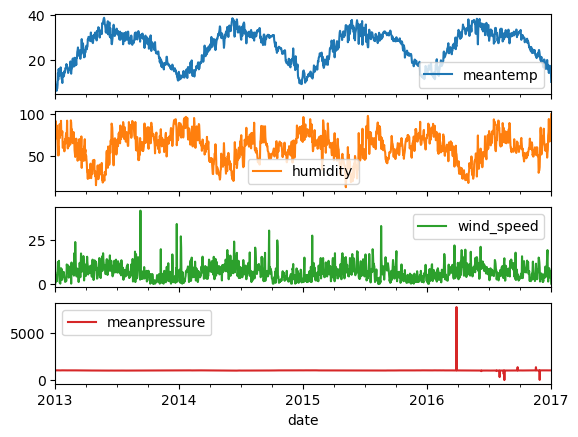

In [56]:
df.plot(subplots=True)

- É perceptível a presença de outliers para a pressão média

{'whiskers': [<matplotlib.lines.Line2D at 0x7a8d24032bd0>,
 'caps': [<matplotlib.lines.Line2D at 0x7a8d24038450>,
 'boxes': [<matplotlib.lines.Line2D at 0x7a8d243f5810>],
 'medians': [<matplotlib.lines.Line2D at 0x7a8d24039950>],
 'fliers': [],
 'means': []}

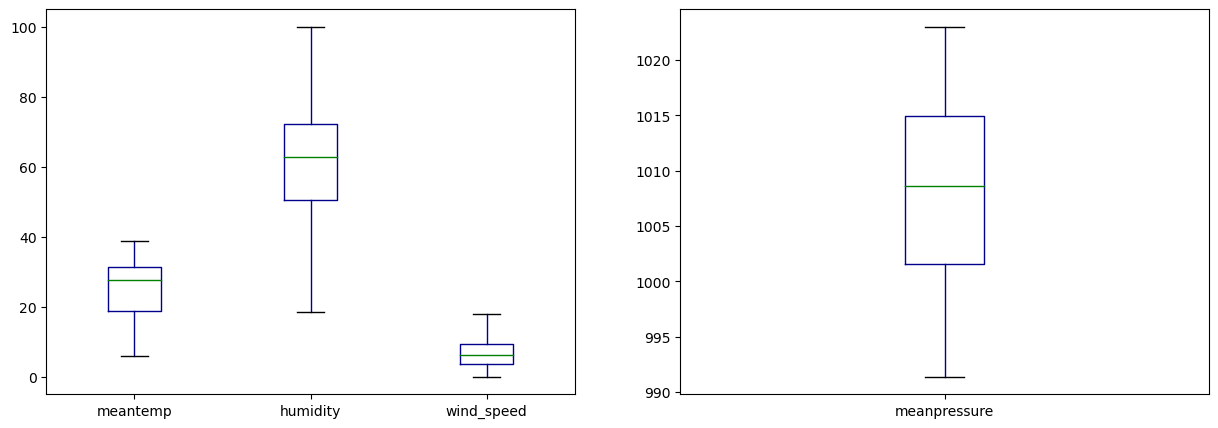

In [57]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
cl1 = df[list(df.columns)[:-1]]
cl2 = df[list(df.columns)[-1:]]
#plt.boxplot(cl1,)
ax1.boxplot(cl1,
    boxprops=dict(color='darkblue'),
    capprops=dict(color='black'),
    whiskerprops=dict(color='darkblue'),
    flierprops=dict(color='cyan', markeredgecolor='yellow'),
    medianprops=dict(color='green'),
labels=cl1.columns,showfliers=False)

ax2.boxplot(cl2,
    boxprops=dict(color='darkblue'),
    capprops=dict(color='black'),
    whiskerprops=dict(color='darkblue'),
    flierprops=dict(color='cyan', markeredgecolor='yellow'),
    medianprops=dict(color='green'),
labels=cl2.columns,showfliers=False)
#ax1.boxplot(df[list(df.columns)[:-1]],showfliers=False)
#ax2.boxplot(df[list(df.columns)[-1]],showfliers=False)

#df[list(df.columns)[:-1]].boxplot(showfliers=False)

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

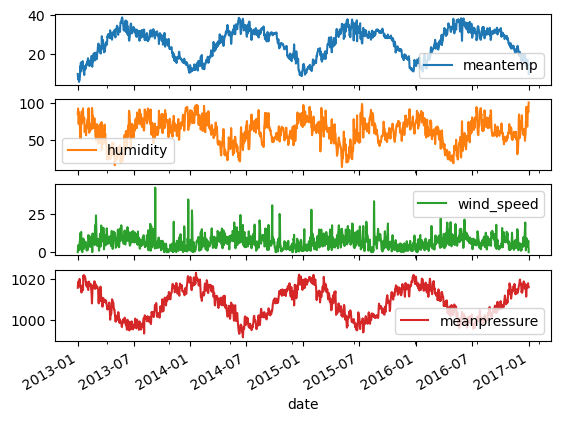

In [58]:
Q1 = df['meanpressure'].quantile(0.25)
Q3 = df['meanpressure'].quantile(0.75)
IQR = Q3 - Q1

filter = (df['meanpressure'] >= Q1 - 1.5 * IQR) & (df['meanpressure'] <= Q3 + 1.5 *IQR)
sml1 = df.loc[filter]
sml1.plot(subplots=True)


In [59]:
cl1 = np.abs(stats.zscore(df.meanpressure))
cl1

date
2013-01-01    0.025321
2013-01-02    0.037162
2013-01-03    0.041972
2013-01-04    0.033647
2013-01-05    0.029946
                ...   
2016-12-28    0.024758
2016-12-29    0.032193
2016-12-30    0.037743
2016-12-31    0.027726
2017-01-01    0.027171
Name: meanpressure, Length: 1462, dtype: float64

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

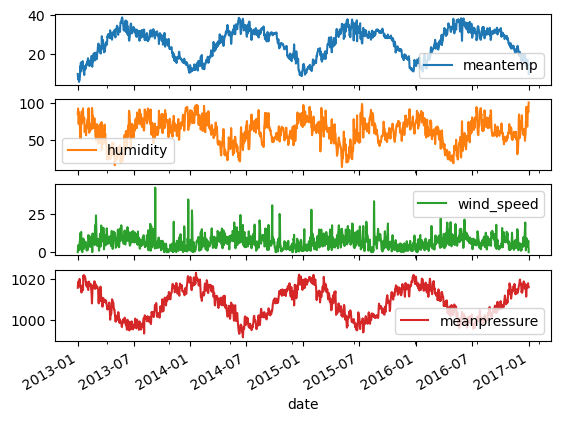

In [60]:
sml2 = df[
    #(np.abs(stats.zscore(df)) < 3).all(axis=1)
    (np.abs(stats.zscore(df.meanpressure)) < 0.359)
]
sml2.plot(subplots=True)

In [61]:
diff_size1 = pd.concat([sml1,sml2]).drop_duplicates(keep=False)
if diff_size1.__len__() == 0:
    print("nenhuma diferença no corte dos outliers em meantemperature")
else:
    print(diff_size1)

nenhuma diferença no corte dos outliers em meantemperature


- Função para gerar as séries de predição

In [93]:
def create_features_labels(df, cols, window_size=7):
    X, y = [], []
    for i in range(len(df) - window_size):
        X.append(df[cols].iloc[i:i+window_size].values.flatten())
        y.append(df[cols].iloc[i+window_size].values.flatten())
    return np.array(X), np.array(y)

- As variáveis de entrada são alocadas num vetor

In [94]:
X_train, y_train = create_features_labels(df,df.columns)
X_test, y_test = create_features_labels(df_test, df_test.columns)
X_train[0], y_train[0]

(array([  10.        ,   84.5       ,    0.        , 1015.66666667,
           7.4       ,   92.        ,    2.98      , 1017.8       ,
           7.16666667,   87.        ,    4.63333333, 1018.66666667,
           8.66666667,   71.33333333,    1.23333333, 1017.16666667,
           6.        ,   86.83333333,    3.7       , 1016.5       ,
           7.        ,   82.8       ,    1.48      , 1018.        ,
           7.        ,   78.6       ,    6.3       , 1020.        ]),
 array([   8.85714286,   63.71428571,    7.14285714, 1018.71428571]))

In [95]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

In [97]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

for i in range(4):
    print(f'r²({df.columns[i]}) = {r2_score(y_test[:,i], y_pred[:,i]):.3f}')
    

r²(meantemp) = 0.866
r²(humidity) = 0.821
r²(wind_speed) = 0.018
r²(meanpressure) = -1.561
